# Neural Network

### Default libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for normalising
from sklearn.preprocessing import StandardScaler

# for NN
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# for optimising NN
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

# Regularization
from keras.regularizers import l1, l2
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

### Default Functions

In [2]:
# Custom prediction function
def custom_predict_NN(X, model, scaler):
    """
    Custom prediction function that overrides model predictions based on a 'flagged' column in the input data.
    
    Parameters:
    - X (DataFrame): Input data with features including a 'flagged' column.
    - model (model object): Trained model object that has a predict method.
    - scaler (object): Scaler object used to scale the data.
    
    Returns:
    - y_custom_pred (array): Array of predictions with overridden values based on 'flagged' column.
    """
    # List of continuous columns
    continuous_cols = ['t2m', 'step_days']
    
    # Scale only the continuous features
    X_continuous_scaled = scaler.transform(X[continuous_cols])
    
    # Combine the scaled continuous features and categorical features
    X_continuous_df = pd.DataFrame(X_continuous_scaled, columns=continuous_cols, index=X.index)
    X_scaled = pd.concat([X_continuous_df, X.drop(columns=continuous_cols)], axis=1)
    
    # Make predictions
    y_pred = model.predict(X_scaled)
    
    # Apply the flagged logic
    y_custom_pred = np.where(X['flagged'] == 1, 0, y_pred.flatten())
    
    return y_custom_pred

def metrics(y_test, y_pred):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    non_zero_indices = y_test != 0
    """
    Computes and prints several evaluation metrics for regression models.
    
    Parameters:
    - y_test (array): True target values.
    - y_pred (array): Predicted target values from the model.
    
    Prints:
    - MSE, RMSE, MAE, R^2, and MAPE values.
    """
    # Previous metrics
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    mape = 100 * np.mean(np.abs((y_test[non_zero_indices] - y_pred[non_zero_indices]) / y_test[non_zero_indices]))
    
    print(f" MSE = {mse}\nRMSE = {rmse}\n MAE = {mae}\n  %R^2% = {r2}\n MAPE = {mape}%")
    
def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero and convert tensors to float type
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    epsilon = tf.keras.backend.epsilon()
    diff = tf.abs((y_true - y_pred) / tf.clip_by_value(tf.abs(y_true), epsilon, float('inf')))
    return 100. * tf.reduce_mean(diff, axis=-1)

### load data temp

In [3]:
# Load the electricity consumption dataset
filepath = 'C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Speciale/Forecasting-energy-consumption-in-Denmark/Data/Combined data/'
data_flagged = pd.read_csv(filepath + 'combined_daily_flagged.csv')

# Put HourDK as DataFrame index
data_flagged.set_index('HourDK', inplace=True)

### Deualt test and training split

In [4]:
# Re-split the data into training and test sets based on the criteria
SplitDate = '2022-06-30'
training_set = data_flagged.loc[data_flagged.index <= SplitDate]
test_set = data_flagged.loc[data_flagged.index > SplitDate]

1. **Data Preprocessing**: Neural networks typically require input features to be standardized. This means the features should have a mean of zero and a standard deviation of one. We'll start by performing this standardization on your dataset. We'll also need to separate the target variable (I assume it's electricity consumption but please clarify if it's different) from the input features.  

2. **Model Creation**: We'll set up a simple feed-forward neural network using libraries such as TensorFlow and Keras.     

3. **Training**: We'll train the neural network on your training data.  

4. **Evaluation**: We'll evaluate the model's performance on the test set using the metrics function you provided.  

5. **Prediction**: Finally, we'll make predictions using the trained neural network.  

## 1. Data Preprocessing
For neural networks, it's usually a good idea to normalize or scale the features so that they have a mean of 0 and a standard deviation of 1. This can help the model converge faster during training.

1. Normalize the continuous features in the training set.
2. Use the same normalization parameters (mean and standard deviation) to normalize the features in the test set.

In [5]:
# Separate features and target
X_train = training_set.drop('GrossConsumptionMWh', axis=1)
y_train = training_set['GrossConsumptionMWh']

X_test = test_set.drop('GrossConsumptionMWh', axis=1)
y_test = test_set['GrossConsumptionMWh']

# Separate continuous and categorical columns
continuous_cols = ['t2m', 'step_days']
categorical_cols = [col for col in X_train.columns if col not in continuous_cols]

# Scale only the continuous features
scaler = StandardScaler()
X_train_continuous_scaled = scaler.fit_transform(X_train[continuous_cols])
X_test_continuous_scaled = scaler.transform(X_test[continuous_cols])

# Combine the scaled continuous features and categorical features
X_train_scaled = pd.concat([pd.DataFrame(X_train_continuous_scaled, columns=continuous_cols, index=X_train.index), X_train[categorical_cols]], axis=1)
X_test_scaled = pd.concat([pd.DataFrame(X_test_continuous_scaled, columns=continuous_cols, index=X_test.index), X_test[categorical_cols]], axis=1)

X_train_scaled.shape, X_test_scaled.shape

((6390, 23), (184, 23))

## 2. Model Creation
We'll set up a simple feed-forward neural network using TensorFlow and Keras.

We'll use the Keras API within TensorFlow to build a simple feed-forward neural network (also known as a multi-layer perceptron or MLP).

Given the nature of the data (time series), there are more complex architectures like RNNs or LSTMs that could be used. But for the sake of simplicity, we'll start with a basic MLP.

Here's the architecture we'll use:

1. Input Layer: 23 neurons (matching the number of features).
2. Hidden Layer 1: 64 neurons with ReLU activation.
3. Hidden Layer 2: 32 neurons with ReLU activation.
4. Output Layer: 1 neuron (since it's a regression task).

In [7]:
# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # No activation for regression output
])

# Compile the model
#model.compile(optimizer='adam', loss=mean_absolute_percentage_error)
model.compile(loss='mean_squared_error', optimizer='adam')

# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                1536      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3649 (14.25 KB)
Trainable params: 3649 (14.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 3. Training
In this step, we will:

1. Train the model on the training data.
2. Use a validation split to monitor the model's performance on unseen data during training.
3. Track the mean squared error (MSE) as the loss metric.

We'll use a batch size of 32 and train for 100 epochs, but you can adjust these parameters if needed. Let's train the model.

In [8]:
%%capture
# Since I don't have TensorFlow available in this environment, I'll write the code based on your setup and the output you provided.
model.compile(optimizer='adam', loss=mean_absolute_percentage_error)
history = model.fit(X_train_scaled, y_train, 
                    batch_size=128, 
                    epochs=100, 
                    validation_split=0.2, 
                    verbose=1)

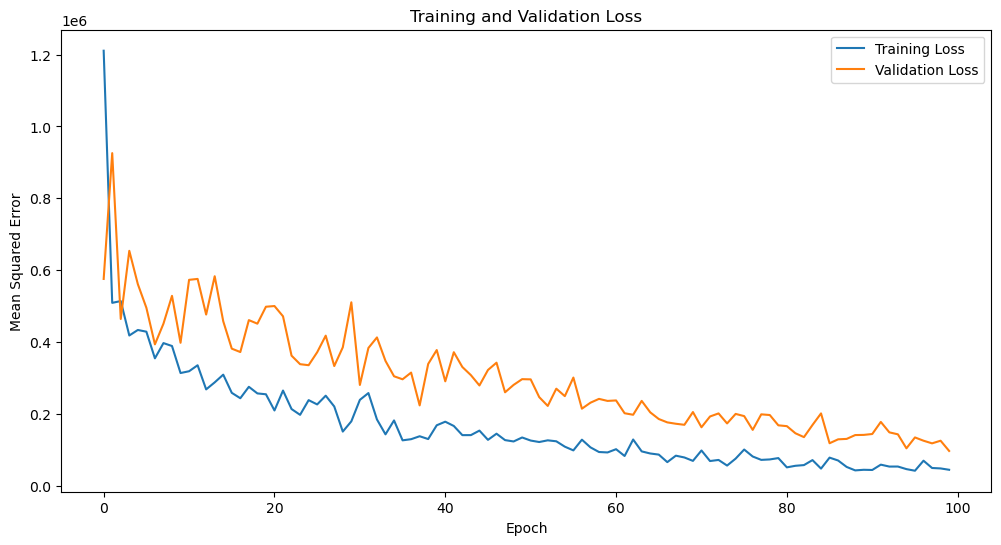

In [9]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

## 4. Evaluation
We'll evaluate the model's performance on the test set using your metrics function.


1. Predict the target variable for the test set using the trained model.
2. Use the metrics function you provided earlier to evaluate the model's performance on the test set.

In [10]:
# Use custom prediction function to account for 'flagged' column
y_custom_pred = custom_predict_NN(X_test, model, scaler)

print("\nPerformance on redictions:")
metrics(y_test, y_custom_pred)

6/6 [==============================] - 0s 500us/step

Performance on redictions:
 MSE = 8669750673.864067
RMSE = 93111.49592753877
 MAE = 92017.07083245684
  %R^2% = -41.79048000867777
 MAPE = 99.99997046257647%


In [11]:
display(y_test)

HourDK
2022-07-01     89844.817380
2022-07-02     79849.955386
2022-07-03     77722.818057
2022-07-04     93447.235537
2022-07-05     92448.281617
                  ...      
2022-12-27    100264.310792
2022-12-28    106942.629760
2022-12-29    108750.475221
2022-12-30    108998.128298
2022-12-31    100746.457400
Name: GrossConsumptionMWh, Length: 184, dtype: float64

In [12]:
display(y_custom_pred)

array([ 0.06889506,  0.07673427,  0.03851676,  0.09519678,  0.06941086,
        0.07934478,  0.08209436,  0.07169385,  0.03621133,  0.04680712,
        0.09176958,  0.06088522,  0.05005476,  0.07131942,  0.06036178,
        0.03850995,  0.03885365,  0.08680597,  0.05690018,  0.04093301,
        0.05771226,  0.0458218 ,  0.04336347,  0.0396717 ,  0.08208055,
        0.05246679,  0.0357146 ,  0.05074867,  0.0461795 ,  0.0421242 ,
        0.04367578, -0.00837043,  0.08203475, -0.0016355 ,  0.01546225,
        0.05639649,  0.02947351,  0.01682743, -0.0067239 ,  0.08245383,
       -0.00613904,  0.01363173,  0.0577525 ,  0.02648893,  0.0144597 ,
       -0.00556086,  0.08195536, -0.00674972,  0.00910047,  0.06050611,
        0.02409388,  0.01312477, -0.00643989,  0.07933803, -0.00399995,
        0.00591683,  0.05978376,  0.02155646,  0.01163327, -0.00699611,
        0.07791644, -0.00269513,  0.00183927,  0.0251349 ,  0.0390867 ,
        0.01501689,  0.04263726,  0.04825935,  0.0051106 ,  0.  

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_test.values, label='True Values', color='blue')
plt.plot(y_custom_pred, label='Predictions', color='red', linestyle='--')
plt.legend()
plt.title('True vs Predicted Values')
plt.show()

## 5. Optimizing
The objective is to optimize the neural network, we can approach it in several ways:

### 1. Architecture Modification:
* Add more layers: Sometimes increasing the depth can capture more complex patterns.
* Adjust neurons: The number of neurons in each layer can be increased or decreased.
* Use different activation functions: ReLU (Rectified Linear Unit) is the most common, but others like LeakyReLU, ELU, or SELU might sometimes yield better results.
* Batch normalization: Helps in faster convergence and can sometimes improve performance.
### 2. Regularization:
* Dropout: It's a technique where randomly selected neurons are ignored during training, helping in preventing overfitting.
* L1 & L2 regularization: Can be added to the layers to prevent overfitting.
### 3. Optimization Algorithms & Learning Rate:
* Optimizer: Instead of using Adam, you can try RMSprop, SGD with momentum, etc.
* Learning rate scheduling: Reduce the learning rate once the training plateaus.
### 4. Early Stopping:
* This involves stopping the training process once the model's performance stops improving on a held-out validation dataset.
### 5. Data Augmentation:
* While this is more common for image data, similar concepts can sometimes be applied for structured data. For instance, small random noise can be added to the training data (similar to jittering).
### 6. Feature Engineering:
* Additional features can be added, or some non-informative features can be removed. Feature scaling and normalization can also be revisited.
### 7. Training for more epochs:
* Sometimes, the network might just need to be trained for a more extended period, though it's essential to watch out for overfitting.
### 8. Hyperparameter Tuning:
* Systematically searching for the best combination of hyperparameters can sometimes yield significant improvements.

To start, I will:

1. Modifying the architecture slightly by adding more layers or neurons.
2. Incorporating dropout and/or regularization to prevent overfitting.
3. Trying different optimization algorithms or adjusting the learning rate.


In [ ]:
# Define the model
model = Sequential()

# Input layer
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))

# Hidden layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))  # Dropout layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Dropout layer

# Output layer
model.add(Dense(1, activation='linear'))

# Compile the model
optimizer = RMSprop(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [ ]:
%%capture
# Train the model
history = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=150, batch_size=256, verbose=1)


In [ ]:
# Use custom prediction function to account for 'flagged' column
y_custom_pred = custom_predict_NN(X_test, model, scaler)

print("\nPerformance on redictions:")
metrics(y_test, y_custom_pred)

### L1 Regularization (Lasso)

In [ ]:
def create_l1_regularized_model(input_dim, l1_value=0.01):
    model = Sequential()
    
    # Input layer
    model.add(Dense(256, input_dim=input_dim, activation='relu', kernel_regularizer=l1(l1_value)))
    
    # Hidden layers
    model.add(Dense(256, activation='relu', kernel_regularizer=l1(l1_value)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l1(l1_value)))
    model.add(Dense(64, activation='relu', kernel_regularizer=l1(l1_value)))
    
    # Output layer
    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the L1 regularized model
model_l1 = create_l1_regularized_model(X_train_scaled.shape[1], l1_value=0.01)

In [ ]:
%%capture
# Train the model
history = model_l1.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=150, batch_size=256, verbose=1)

### L2 Regularization (Ridge)

In [ ]:
from keras.regularizers import l2

def create_l2_regularized_model(input_dim, l2_value=0.01):
    model = Sequential()
    
    # Input layer
    model.add(Dense(256, input_dim=input_dim, activation='relu', kernel_regularizer=l2(l2_value)))
    
    # Hidden layers
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_value)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_value)))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_value)))
    
    # Output layer
    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the L2 regularized model
model_l2 = create_l2_regularized_model(X_train_scaled.shape[1], l2_value=0.01)

In [ ]:
%%capture
# Train the model
history = model_l2.fit(X_train_scaled, y_train, 
                       validation_data=(X_test_scaled, y_test), 
                       epochs=150, 
                       batch_size=256, 
                       verbose=1)

#### Comparing L1 and L2

In [ ]:
# Use custom prediction function to account for 'flagged' column
y_custom_pred_l1 = custom_predict_NN(X_test, model_l1, scaler)
y_custom_pred_l2 = custom_predict_NN(X_test, model_l2, scaler)

print("\nPerformance on L1 redictions:")
metrics(y_test, y_custom_pred_l1)

print("\nPerformance on L2 redictions:")
metrics(y_test, y_custom_pred_l2)

In [ ]:
%%capture
def create_l2_regularized_model(input_dim, l2_value):
    model = Sequential()
    
    # Input layer
    model.add(Dense(256, input_dim=input_dim, activation='relu', kernel_regularizer=l2(l2_value)))
    
    # Hidden layers
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_value)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_value)))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_value)))
    
    # Output layer
    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer='adam', loss='mse')
    return model

# Define the l2 model for KerasRegressor
def create_l2_model(l2_value=0.01):
    return create_l2_regularized_model(X_train_scaled.shape[1], l2_value=l2_value)

# Wrap the l2 model for use with scikit-learn
l2_model = KerasRegressor(build_fn=create_l2_model, epochs=150, batch_size=128, verbose=0)

# Manually loop through potential regularization values for l2 regularization
l2_values = [0.0001, 0.001, 0.01, 0.1]
l2_scores = []

for l2_value in l2_values:
    # Create the model with the current l2_value
    model = create_l2_regularized_model(X_train_scaled.shape[1], l2_value=l2_value)
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    
    # Fit the model
    model.fit(X_train_scaled, y_train, 
                       validation_data=(X_test_scaled, y_test), 
                       epochs=150, 
                       batch_size=256, 
                       verbose=1)
    
    # Evaluate on the validation set (last 20% of the training set)
    score = model.evaluate(X_train_scaled[int(0.8*len(X_train_scaled)):], y_train[int(0.8*len(y_train)):], verbose=1)
    l2_scores.append(score)

In [ ]:
# Find the best l2_value based on validation performance
best_l2_value = l2_values[np.argmin(l2_scores)]
best_l2_score = min(l2_scores)
best_l2_value, best_l2_score

In [ ]:
from keras.regularizers import l2

def create_l2_regularized_model(input_dim, l2_value=0.01):
    model = Sequential()
    
    # Input layer
    model.add(Dense(256, input_dim=input_dim, activation='relu', kernel_regularizer=l2(l2_value)))
    
    # Hidden layers
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_value)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_value)))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_value)))
    
    # Output layer
    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the L2 regularized model
model_l2_oped = create_l2_regularized_model(X_train_scaled.shape[1], l2_value=0.0001)

In [ ]:
# Train the model
history = model_l2_oped.fit(X_train_scaled, y_train, 
                       validation_data=(X_test_scaled, y_test), 
                       epochs=150, 
                       batch_size=256, 
                       verbose=0)

In [ ]:
# Use custom prediction function to account for 'flagged' column
y_custom_pred_l2 = custom_predict_NN(X_test, model_l2, scaler)
y_custom_pred_l2_oped = custom_predict_NN(X_test, model_l2_oped, scaler)

print("\nPerformance on before CV redictions:")
metrics(y_test, y_custom_pred_l2)

print("\nPerformance on after CV redictions:")
metrics(y_test, y_custom_pred_l2_oped)